In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/content/drive/Shared drives/SIH2020/Dataset/atomdata/datawithoutgroup.csv')
df.head()

,Unnamed: 0,RF,UTC_Start,UTC_Stop,Latitude,Longitude,Altitude (m masl GPS),Speed,Acceleration
0,0,1.0,0.0,10.0,34.630960,-118.107350,799.533333,0.000665,0.000033
1,1,1.0,10.0,20.0,34.630694,-118.113999,842.990000,0.000994,0.000003
2,2,1.0,20.0,30.0,34.630241,-118.123933,918.600000,0.001027,0.000004
3,3,1.0,30.0,40.0,34.629899,-118.134193,980.130000,0.001065,-0.000004
4,4,1.0,40.0,50.0,34.630087,-118.144843,1037.710000,0.001029,0.000003


In [3]:
df.columns
df.rename(columns={'Altitude (m masl GPS)':'Altitude'},inplace=True)
df.head()

,Unnamed: 0,RF,UTC_Start,UTC_Stop,Latitude,Longitude,Altitude,Speed,Acceleration
0,0,1.0,0.0,10.0,34.630960,-118.107350,799.533333,0.000665,0.000033
1,1,1.0,10.0,20.0,34.630694,-118.113999,842.990000,0.000994,0.000003
2,2,1.0,20.0,30.0,34.630241,-118.123933,918.600000,0.001027,0.000004
3,3,1.0,30.0,40.0,34.629899,-118.134193,980.130000,0.001065,-0.000004
4,4,1.0,40.0,50.0,34.630087,-118.144843,1037.710000,0.001029,0.000003


In [4]:
data = df[['Latitude','Longitude','Altitude']]
data.head()

,Latitude,Longitude,Altitude
0,34.630960,-118.107350,799.533333
1,34.630694,-118.113999,842.990000
2,34.630241,-118.123933,918.600000
3,34.629899,-118.134193,980.130000
4,34.630087,-118.144843,1037.710000


In [5]:

new = data.shift(-1,axis=0)
new.head()

,Latitude,Longitude,Altitude
0,34.630694,-118.113999,842.99
1,34.630241,-118.123933,918.60
2,34.629899,-118.134193,980.13
3,34.630087,-118.144843,1037.71
4,34.631843,-118.154980,1109.23


In [6]:
final = pd.concat([data,new],axis=1)
final.head()

,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude
0,34.630960,-118.107350,799.533333,34.630694,-118.113999,842.99
1,34.630694,-118.113999,842.990000,34.630241,-118.123933,918.60
2,34.630241,-118.123933,918.600000,34.629899,-118.134193,980.13
3,34.629899,-118.134193,980.130000,34.630087,-118.144843,1037.71
4,34.630087,-118.144843,1037.710000,34.631843,-118.154980,1109.23


In [7]:
print(len(final))
final.dropna(inplace=True)
print(len(final))

166400
166399


In [8]:
values = final.values
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
X = values[:,:3]
Y = values[:,3:]

In [9]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=1000,shuffle=True)

In [10]:
print(X_train.shape,X_test.shape)

(165399, 3) (1000, 3)


In [11]:
X_train = np.reshape(X_train,(165399,1,3))
X_test = np.reshape(X_test,(1000,1,3))


In [12]:
def create_model():
  model = Sequential()
  model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(3))
  return model


In [13]:
def train_model(filepath):
  model = create_model()
  model.compile(loss='mae', optimizer='adam')
  # fit network
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
  history = model.fit(X_train, Y_train, epochs=50, batch_size=100, validation_data=(X_test, Y_test), verbose=2, shuffle=False,callbacks=[checkpoint])
  return history

In [14]:
filepath = '/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep.hdf5'
history = train_model(filepath)

Train on 165399 samples, validate on 1000 samples
Epoch 1/50
 - 11s - loss: 0.0274 - val_loss: 0.0021

Epoch 00001: val_loss improved from inf to 0.00205, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep.hdf5
Epoch 2/50
 - 11s - loss: 0.0020 - val_loss: 0.0018

Epoch 00002: val_loss improved from 0.00205 to 0.00179, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep.hdf5
Epoch 3/50
 - 11s - loss: 0.0019 - val_loss: 0.0017

Epoch 00003: val_loss improved from 0.00179 to 0.00171, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep.hdf5
Epoch 4/50
 - 11s - loss: 0.0019 - val_loss: 0.0018

Epoch 00004: val_loss did not improve from 0.00171
Epoch 5/50
 - 11s - loss: 0.0018 - val_loss: 0.0016

Epoch 00005: val_loss improved from 0.00171 to 0.00156, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep.hdf5
Epoch 6/50
 - 11s - loss: 0.0018 - val_loss: 0.001

In [15]:
model = create_model()
model.load_weights(filepath)

yhat = model.predict(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[2]))

yhat = np.concatenate((yhat,X_test),axis=1)
inv_yhat = scaler.inverse_transform(yhat)

Y_test = np.concatenate((Y_test,X_test),axis=1)
inv_y = scaler.inverse_transform(Y_test)

d1 = pd.DataFrame(inv_yhat)
d2 = pd.DataFrame(inv_y)

inv_yhat = d1.iloc[:,:3]
inv_y = d2.iloc[:,:3]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
#rmse = math.sqrt(mean_squared_error(yhat,Y_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 33.157


In [16]:
yhat

array([[2.24847078e-01, 3.43806297e-01, 5.51753938e-01, 2.24846226e-01,
        3.43599422e-01, 5.50860486e-01],
       [8.53289843e-01, 6.16898276e-02, 6.47152841e-01, 8.53133394e-01,
        6.20553523e-02, 6.46812623e-01],
       [6.86491907e-01, 1.68910712e-01, 2.99041927e-01, 6.86495231e-01,
        1.69293157e-01, 2.99313169e-01],
       ...,
       [7.24440992e-01, 1.71233445e-01, 9.14326072e-01, 7.24261066e-01,
        1.71415013e-01, 9.14908000e-01],
       [8.27318788e-01, 5.20734154e-02, 6.77869618e-01, 8.27112323e-01,
        5.23915853e-02, 6.77513193e-01],
       [5.09836078e-01, 5.00195324e-01, 2.03538686e-04, 5.09568537e-01,
        4.99999265e-01, 0.00000000e+00]])

In [17]:
inv_yhat.head()

,0,1,2
0,-48.151278,-56.229386,7296.675473
1,58.129163,-157.791166,8558.279219
2,29.920774,-119.191704,3954.682952
3,70.813773,-148.323369,3024.286962
4,67.258297,-47.536402,6946.231653


In [18]:
d1.iloc[:,3:].head()

,3,4,5
0,-48.151422,-56.303861,7284.86
1,58.102705,-157.659577,8553.78
2,29.921336,-119.054024,3958.27
3,70.823889,-148.140433,3030.13
4,67.203287,-47.482183,6944.08


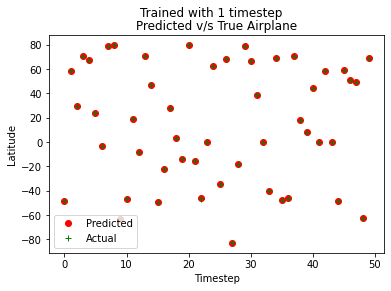

In [40]:
t = np.arange(50)
x_pred = d1.iloc[:50,0]
x_true = d2.iloc[:50,0]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Latitude')
plt.title('Predicted v/s True Airplane')
plt.suptitle('Trained with 1 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_lat_time.png')
plt.show()